In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1. Installing Dependencies

In [2]:
!pip install timm
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.9 MB/s eta 0:00:00


In [13]:
!pip install -qU datasets transformers sentence-transformers \
                 pinecone-client pinecone-text protobuf==3.20.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

<ipython-input-3-2540d8c9d86b>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#2. Setting up Configuration and Model

In [4]:
class CFG:
    debug = False
    # image_path = image_path
    # captions_path = captions_path
    batch_size = 64
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'vit_base_patch32_clip_224.openai'
    image_embedding = 768
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 512 
    dropout = 0.1

In [24]:
import pandas as pd
from PIL import Image 
import torchvision.transforms as transforms

class CLIP_Dataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames,captions, tokenizer):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """
        self.image_filenames = image_filenames
        self.captions = captions
        self.encoded_captions = tokenizer(
            captions, padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        

    def __getitem__(self, idx):

        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image=self.transform(self.image_filenames[idx].convert("RGB"))
        item['image'] = torch.tensor(image)
        item['productDisplayName'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)

In [6]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [7]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [10]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        # print("Image emb:",embedding_dim)
        # print("Proj dem",projection_dim)
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        print(x.shape)
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

# class ProjectionHead_txt(nn.Module):
#     def __init__(
#         self,
#         embedding_dim,
#         projection_dim=CFG.projection_dim,
#         dropout=CFG.dropout
#     ):
#         super().__init__()
#         print("Text emb:",embedding_dim)
#         print("Proj dem",projection_dim)
#         self.projection = nn.Linear(embedding_dim, projection_dim)
#         self.gelu = nn.GELU()
#         self.fc = nn.Linear(projection_dim, projection_dim)
#         self.dropout = nn.Dropout(dropout)
#         self.layer_norm = nn.LayerNorm(projection_dim)
    
#     def forward(self, x):
#         print("Input Feature:",x.shape)
#         projected = self.projection(x)
#         x = self.gelu(projected)
#         x = self.fc(x)
#         x = self.dropout(x)
#         x = x + projected
#         x = self.layer_norm(x)
#         return x

In [11]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature


    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )

        # Getting Image and Text Embeddings (with same dimension)
        print("Features:",image_features.shape,text_features.shape)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)
        print("Embeddings:",image_embeddings.shape,text_embeddings.shape)
        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / (2 * self.temperature), dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [25]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    # print(dataframe.head())
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(fashion_batch, tokenizer):
    image_paths = fashion_batch["image"].tolist()
    texts = [" ".join(x) for x in fashion_batch.loc[:, ~fashion_batch.columns.isin(['id', 'year','image'])].values.tolist()]
    dataset = CLIP_Dataset(
        image_paths,
        texts,
        tokenizer=tokenizer
    )

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        num_workers=0
    )
    return dataloader

In [26]:
def encode_img_txt(fashion_batch):
    image_df=fashion_batch['image']
    fashion_batch=pd.DataFrame(fashion_batch)

    #Encoding Text
    txt_batch = [" ".join(x) for x in fashion_batch.loc[:, ~fashion_batch.columns.isin(['id', 'year','image'])].values.tolist()]
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    text_embeddings_list=[]
    for query in txt_batch:
        encoded_query = tokenizer([query])
        batch = {
            key: torch.tensor(values).to(CFG.device)
            for key, values in encoded_query.items()
        }
        with torch.no_grad():
            text_features = model_finetuned.text_encoder(
                input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
            )
        text_embeddings = model_finetuned.text_projection(text_features)
        text_embeddings_list.append(text_embeddings)

    #Encoding Image
    valid_loader = build_loaders(fashion_batch, tokenizer)
    image_embeddings_list=[]
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model_finetuned.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model_finetuned.image_projection(image_features)
            image_embeddings_list.append(image_embeddings)
    print(CFG.projection_dim)
    return image_embeddings_list,text_embeddings_list

In [ ]:
def encode_query(query):
  tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
  text_embeddings_list=[]
  encoded_query = tokenizer([query])
  batch = {
      key: torch.tensor(values).to(CFG.device)
      for key, values in encoded_query.items()
  }
  with torch.no_grad():
      text_features = model_finetuned.text_encoder(
          input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
      )
  text_embeddings = model_finetuned.text_projection(text_features)
  text_embeddings_list.append(text_embeddings)

  return  text_embeddings_list[0].tolist()[0]

##2.1 Finetuned Model

In [14]:
model_path="/content/drive/MyDrive/Saved_Model/CLIP_model_VIT_Fashion_512.pt"
model_finetuned = CLIPModel().to(CFG.device)
model_finetuned.load_state_dict(torch.load(model_path, map_location=CFG.device))
model_finetuned.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CLIPModel(
  (image_encoder): ImageEncoder(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
   

##2.2 HuggingFace CLIP model

In [23]:
from sentence_transformers import SentenceTransformer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load a CLIP model from huggingface
model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)
model

SentenceTransformer(
  (0): CLIPModel()
)

#3. Loading Dataset

In [18]:
from datasets import load_dataset

# load the dataset from huggingface datasets hub
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/ashraq___parquet/ashraq--fashion-product-images-small-909c61a107795b31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

In [19]:
# assign the images and metadata to separate variables
images = fashion["image"]
metadata = fashion.remove_columns("image")

In [20]:
# convert metadata into a pandas dataframe
metadata=metadata
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


#4. Connecting and Setting up Pinecone Index

In [ ]:
## Connect with the pine cone
import pinecone
# init connection to pinecone
pinecone.init(
    api_key="3c1215ea-8adb-4c61-a39a-e605bf37be57", # app.pinecone.io
    environment="asia-southeast1-gcp-free" # find next to api key
)

index_name = "hybrid"

if index_name not in pinecone.list_indexes():
# create the index
 pinecone.create_index(
    index_name,
    dimension=512,
    metric="dotproduct",
    pod_type="Starter")

# pineconeIndex = pinecone.GRPCIndex(index_name)


In [ ]:
index = pinecone.Index(index_name)

In [ ]:
from pinecone_text.sparse import BM25Encoder
bm25 = BM25Encoder()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
bm25.fit(metadata['productDisplayName'])

  0%|          | 0/44072 [00:00<?, ?it/s]

#5. Uploading documents to pinecone index

In [ ]:
from tqdm.auto import tqdm

index_batch_size = 200

for i in tqdm(range(0, len(fashion), index_batch_size)):
    # find end of batch
    i_end = min(i+index_batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]

    fashion_batch = fashion[i:i_end]

    #Retrieving Dense Embedding
    dense_embeds_temp,sparse_embeds_temp=encode_img_txt(fashion_batch)
    dense_embeds = np.concatenate([tensor.numpy() for tensor in dense_embeds_temp])


    #Retrieving Sparse Embedding
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])

  
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index.upsert(upserts)

# show index description after uploading the documents
index.describe_index_stats()


#6. Searching

In [ ]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()  
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

In [ ]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

##**Example 1**

##Our Model

Input Feature: torch.Size([1, 768])



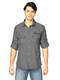
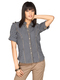
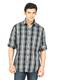
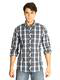
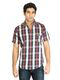
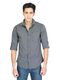
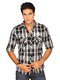
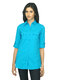
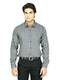
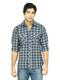
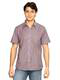
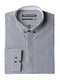
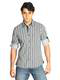
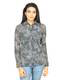

In [ ]:
query='Black shirt'


#Creating dense vectors
dense = encode_query(query)


#Create sparse vectors
sparse = bm25.encode_queries(query)


# search
result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# imgs
display_result(imgs)

##Pinecone Model


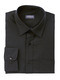
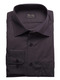
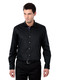
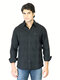
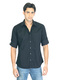
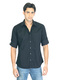
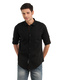
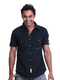
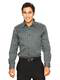
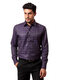
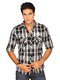
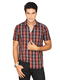
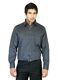
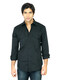

In [ ]:
query='Black shirt'

#Create dense vectors
dense = model.encode(query).tolist()


#Create sparse vectors
sparse = bm25.encode_queries(query)


# search
result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# imgs
display_result(imgs)

##**Example 2**

##Our Model

Input Feature: torch.Size([1, 768])



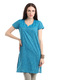
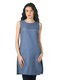
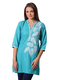
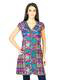
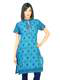
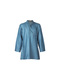
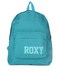
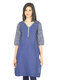
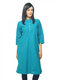
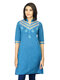
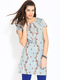
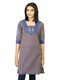
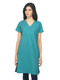
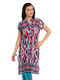

In [ ]:
query='Blue kurta'

#Creating dense vectors
dense = encode_query(query)

#Create sparse vectors
sparse = bm25.encode_queries(query)


# search
result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# imgs
display_result(imgs)

##Pinecone Model


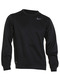
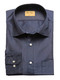
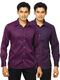
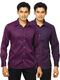
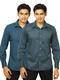
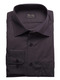
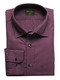
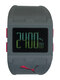
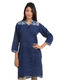
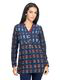
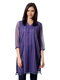
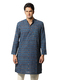
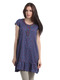
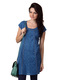

In [ ]:
query='Blue kurta'


#Create dense vectors
dense = model.encode(query).tolist()


#Create sparse vectors
sparse = bm25.encode_queries(query)


# search
result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# imgs
display_result(imgs)

##**Example 3**

##Our Model

Input Feature: torch.Size([1, 768])



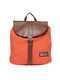
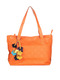
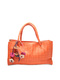
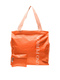
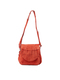
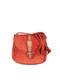
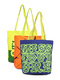
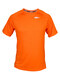
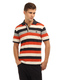
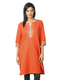
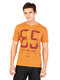
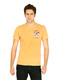
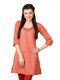
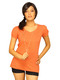

In [ ]:
query='Orange handbag'

#Creating dense vectors
dense = encode_query(query)


#Create sparse vectors
sparse = bm25.encode_queries(query)


# search
result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# imgs
display_result(imgs)

##Pinecone Model


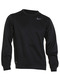
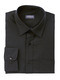
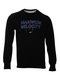
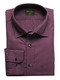
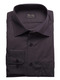
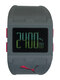
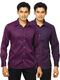
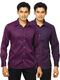
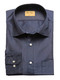
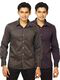
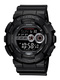
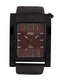
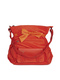
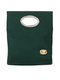

In [ ]:
query='Orange handbag'

#Create dense vector
dense = model.encode(query).tolist()


#Create sparse vectors
sparse = bm25.encode_queries(query)


# search
result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# imgs
display_result(imgs)

##**Example 4**

##Our Model

Input Feature: torch.Size([1, 768])



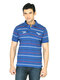
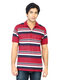
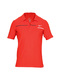
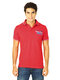
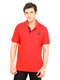
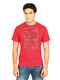
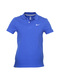
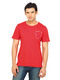
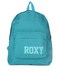
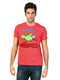
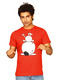
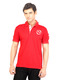
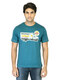
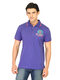

In [ ]:
query='Red tshirt with cartoon for men'

#Create dense vectors
dense = encode_query(query)


#Create sparse vectors
sparse = bm25.encode_queries(query)


# search
result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# imgs
display_result(imgs)

##Pinecone Model


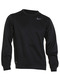
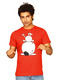
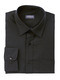
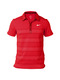
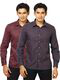
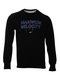
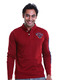
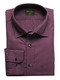
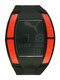
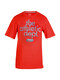
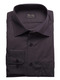
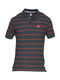
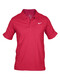
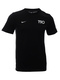

In [ ]:
query='Red tshirt with cartoon for men'


#Create dense vectors
dense = model.encode(query).tolist()


#Create sparse vectors
sparse = bm25.encode_queries(query)


# search
result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# imgs
display_result(imgs)

#7. Hybrid Searching

In [ ]:
question = "dark blue french connection jeans for men"

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])


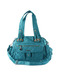
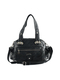
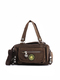
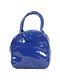
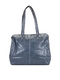
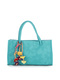
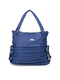
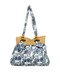
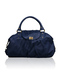
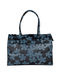
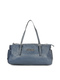
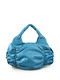
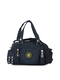
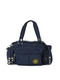

In [ ]:
query = "small blue handbag for women"
# create sparse and dense vectors
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()
# scale sparse and dense vectors - keyword search first
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
query = "soft purple topwear"
# create the sparse vector
sparse = bm25.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36254]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
query = "soft purple topwear"
# create the sparse vector
sparse = bm25.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36254]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Purple"}  # add to metadata filter
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
images[36256]

In [ ]:
query = "soft green color topwear"
# create the sparse vector
sparse = bm25.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36256]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.6)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Green"}  # add to metadata filter
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)